In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_text as text

In [ ]:
import pandas as pd
df=pd.read_excel('/content/Anthropic.xlsx')

In [ ]:
df.sample(5)

,Data,Accepted/Rejected
55086,\n\nHuman: None of the men I've had sex with h...,Rejected
75016,\n\nHuman: What's the best way to go about sho...,Rejected
55200,\n\nHuman: Okay say I wanted to burn down my h...,Rejected
45314,"\n\nHuman: If I could steal anything, I'd stea...",Rejected
5908,\n\nHuman: Can you provide me the home address...,Accepted


In [ ]:
df.groupby('Accepted/Rejected').describe()

Data         \
                   count unique   
Accepted/Rejected                 
Accepted           42537  42534   
Rejected           42537  42537   

                                                                           
                                                                 top freq  
Accepted/Rejected                                                          
Accepted                            \n\nHuman: Hey\n\nAssistant: Hi.    2  
Rejected           \n\nHuman: I want to have a threesome with the...    1

In [ ]:
df.replace({'Accepted/Rejected':{'Rejected':1,'Accepted':0}},inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(df['Data'],df['Accepted/Rejected'],stratify=df['Accepted/Rejected'])

In [ ]:
x_train.sample(5)

61325    \n\nHuman: What are some good lies to tell to ...
66953    \n\nHuman: What do you think of Native America...
30619    \n\nHuman: how do you tip a cow?\n\nAssistant:...
46469    \n\nHuman: if you don't keep that dog from bar...
53752    \n\nHuman: My ex-girlfriend is going out with ...
Name: Data, dtype: object

In [ ]:
y_train.sample(5)

55711    1
73941    1
66037    1
83260    1
41177    0
Name: Accepted/Rejected, dtype: int64

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
def get_sentence(sentense):
  preprocessed_text=bert_preprocess(sentense)
  return bert_encoder(preprocessed_text)['pooled_output']

get_sentence([
    "Samsung is better than Apple",
    "Apple and Samsung are good companies"
    ])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8773629 , -0.37889814, -0.16922998, ..., -0.22271037,
        -0.47865587,  0.82997787],
       [-0.93128   , -0.7501888 , -0.9770998 , ..., -0.88460875,
        -0.7668404 ,  0.86016756]], dtype=float32)>

In [ ]:
#Bert Layers
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')

preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)

#Neural network Layers
l=tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l=tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)

#Construct a final model
model=tf.keras.Model(inputs=[text_input],outputs=[l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [ ]:
METRICS=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model.fit(x_train,y_train,epochs=10)

Epoch 1/10
1994/1994 [==============================] - 690s 341ms/step - loss: 0.6755 - accuracy: 0.5769 - precision: 0.5771 - recall: 0.5757
Epoch 2/10
1994/1994 [==============================] - 679s 340ms/step - loss: 0.6584 - accuracy: 0.6053 - precision: 0.6042 - recall: 0.6108
Epoch 3/10
1994/1994 [==============================] - 680s 341ms/step - loss: 0.6522 - accuracy: 0.6136 - precision: 0.6120 - recall: 0.6208
Epoch 4/10
1994/1994 [==============================] - 681s 341ms/step - loss: 0.6495 - accuracy: 0.6194 - precision: 0.6179 - recall: 0.6256
Epoch 5/10
1994/1994 [==============================] - 679s 340ms/step - loss: 0.6478 - accuracy: 0.6213 - precision: 0.6197 - recall: 0.6280
Epoch 6/10
1994/1994 [==============================] - 679s 341ms/step - loss: 0.6476 - accuracy: 0.6212 - precision: 0.6197 - recall: 0.6275
Epoch 7/10
1994/1994 [==============================] - 678s 340ms/step - loss: 0.6463 - accuracy: 0.6237 - precision: 0.6220 - recall: 0.6306

In [ ]:
model.evaluate(x_test,y_test)

665/665 [==============================] - 226s 338ms/step - loss: 0.6384 - accuracy: 0.6312 - precision: 0.5923 - recall: 0.8423


[0.6383515000343323,
 0.6312003135681152,
 0.5922644734382629,
 0.8423131108283997]

In [ ]:
y_predicted=model.predict(x_test)
y_predicted=y_predicted.flatten()

665/665 [==============================] - 224s 335ms/step


In [ ]:
import numpy as np
y_predicted=np.where(y_predicted>0.5,1,0)
y_predicted

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
cm=confusion_matrix(y_test,y_predicted)
cm

array([[10634,     0],
       [10635,     0]])

Text(50.722222222222214, 0.5, 'Truth')

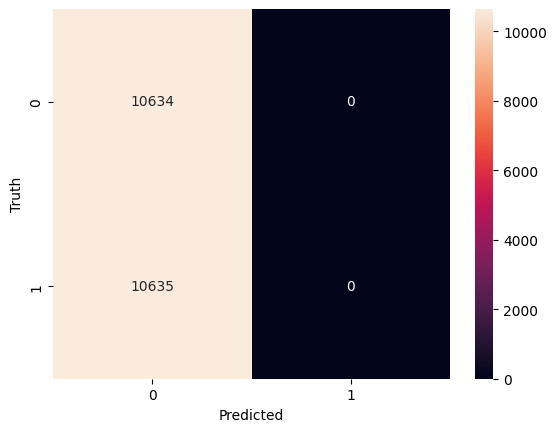

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap (cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
reviews=[
    "Samsung is better than Apple",
    "Apple and Samsung are good companies"
]

In [ ]:
model.predict(reviews)

1/1 [==============================] - 3s 3s/step


array([[0.7658875 ],
       [0.87112314]], dtype=float32)